### Siamese GAN

image_size = 32
channels = 1

in plus fata de tot restu modelelor, cateagoria A are pop blues country, nu doar pop.
Categoria B are doar rock.

Am adaugat self.second in discriminator fara gaussian noise, pt ca la feature matching generatorul capata noise ca asa le vede discriminatoru

v2
lrD = 0.000001
feature matching are 2 *
gen converge pe la 2000

v3
lrD = 0.000001
feature matching are 4 *

In [58]:
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from PIL import Image
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib

In [59]:
ngpu = 0
pathA = "Data/SpectrogramsA"
pathB = "Data/SpectrogramsB"
filename_gen = "TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16_lrd=0.00001/TraVeLGAN-Gen.joblib"
filename_dis = "TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16_lrd=0.00001/TraVeLGAN-Dis.joblib"
filename_sim = "TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16_lrd=0.00001/TraVeLGAN-Siam.joblib"
workers = 2
batch_size = 32

image_size = 32

# channels nr for input images
nc = 1
# size of feature maps in generator
ngf = 64
# size of feature maps in discriminator
ndf = 64
# length of latent vector
lenvec = 128

num_epochs = 7
lr = 0.0002
lrD = 0.00001
beta1 = 0.5

def find_classes(directory:str):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    class_to_index = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_index

In [60]:
class MyImageFolder(torch.utils.data.Dataset):
    def __init__(self, directory:str, transform=None):

        self.paths = list(pathlib.Path(directory).glob('*/*.jpg')) * 3

        self.transform = transform
        self.classes, self.class_to_index = find_classes(directory)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_index = self.class_to_index[class_name]

        if self.transform:
            return self.transform(img), class_index
        else:
            return img, class_index

    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path)

transform = torchvision.transforms.Compose([
            #torchvision.transforms.RandomResizedCrop(image_size),
            #torchvision.transforms.Resize(64),
            #torchvision.transforms.RandomCrop(64),
            # TODO test this
            #torchvision.transforms.RandomResizedCrop(image_size, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
            # torchvision.transforms.RandomHorizontalFlip(p=0.3)

            torchvision.transforms.ToTensor(),  # imaginile sunt normalizate intre [0, 1]
            torchvision.transforms.Normalize(0.5, 0.5),  # imaginile sunt normalizate intre [-1, 1]
        ])


In [61]:
train_data_A = MyImageFolder(directory=pathA, transform=transform)
train_data_B = MyImageFolder(directory=pathB, transform=transform)

dataloader_A = torch.utils.data.DataLoader(train_data_A, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_B = torch.utils.data.DataLoader(train_data_B, batch_size=batch_size, shuffle=True, num_workers=2)

print(len(dataloader_A))
print(len(dataloader_B))
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


539
1538


In [62]:
'''
Gaussian distribution (also known as normal distribution) is a bell-shaped curve, and it is assumed that during any measurement values will follow a normal distribution with an equal number of measurements above and below the mean value.
'''
class GaussianNoise(torch.nn.Module):
    def __init__(self, std=0.1, decay=0):
        super().__init__()
        self.std = std
        self.decay = decay

    def step(self):
        self.std = max(self.std - self.decay, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [63]:
'''
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.
'''
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [64]:
generator = torch.nn.Sequential(
    # 1 x 16 x 16

    # downsampling
    torch.nn.Conv2d(nc, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 8 x 8
    torch.nn.Conv2d(ngf, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf * 2),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 4 x 4


    # upsampling
    torch.nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 8 x 8

    torch.nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.Tanh(),
    # ngf x 16 x 16

)

generator.apply(weights_init)




Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=True)
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=True)
  (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)

In [65]:
# Siamese model

siamese = torch.nn.Sequential(
    # conv2d
    # conv2d
    # conv2d

        # 1 x 32 x 16
    torch.nn.Conv2d(nc, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 16 x 8

    torch.nn.Conv2d(ngf, ngf, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 8 x 8

    torch.nn.Conv2d(ngf, ngf * 2, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(ngf * 2),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 8 x 4

    # # 1 x 16 x 16
    # torch.nn.Conv2d(nc, ngf, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False),
    # torch.nn.BatchNorm2d(ngf),
    # torch.nn.LeakyReLU(True),
    # # ngf x 8 x 16
    #
    # torch.nn.Conv2d(ngf, ngf, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1), bias=False),
    # torch.nn.BatchNorm2d(ngf),
    # torch.nn.LeakyReLU(True),
    # # ngf x 8 x 8
    #
    # torch.nn.Conv2d(ngf, ngf * 2, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1), bias=False),
    # torch.nn.BatchNorm2d(ngf * 2),
    # torch.nn.LeakyReLU(True),
    # # ngf*2 x 8 x 4

    torch.nn.Flatten(),
    # ngf*2*8*4
    torch.nn.Linear(ngf * 64, lenvec)
)

In [66]:
# Discriminator model


class Discriminator(torch.nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()

        self.main = torch.nn.Sequential(
            GaussianNoise(),
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf x 16 x 16

            GaussianNoise(),
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 8 x 8

            GaussianNoise(),
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 4 x 4

            GaussianNoise(),
            torch.nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

        self.second = torch.nn.Sequential(
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf x 16 x 16

            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 8 x 8

            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 4 x 4

            torch.nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

    def get_intermediate_features(self, x):
        intermediate_features = []
        for module in self.second:
            x = module(x)
            intermediate_features.append(x)
        return intermediate_features[1 : -1]

discriminator = Discriminator(nc, ndf)
discriminator.apply(weights_init)



Discriminator(
  (main): Sequential(
    (0): GaussianNoise()
    (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): GaussianNoise()
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): GaussianNoise()
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): GaussianNoise()
    (13): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (14): Sigmoid()
  )
  (second): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride

In [67]:
class IdentityLoss(torch.nn.Module):
    def __init__(self):
        super(IdentityLoss, self).__init__()

    def forward(self, real, generated):
        identity_loss = torch.nn.functional.l1_loss(real, generated)
        return identity_loss

class CosineSimilarityLoss(torch.nn.Module):
    # daca e 1 sunt lfl
    # daca e 0 sunt ortogonali sau unrelated
    # daca e -1 sunt opusi sau dissimilar
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()

    def forward(self, a, b):
        a_normalized = torch.nn.functional.normalize(a, dim=1)
        b_normalized = torch.nn.functional.normalize(b, dim=1)
        cos_sim = torch.mean(torch.nn.functional.cosine_similarity(a_normalized, b_normalized, dim=1))
        return cos_sim

class SiameseLoss(torch.nn.Module):
    def __init__(self, margin):
        super(SiameseLoss, self).__init__()
        self.margin = margin

    def forward(self, a1, a2):
        distances = torch.sqrt(torch.sum((a1 - a2) ** 2, dim=-1, keepdim=True))
        hinge_loss = torch.square(torch.maximum((self.margin - distances), torch.tensor(0)))
        loss = torch.mean(hinge_loss)
        return loss

In [68]:
adversarial_loss = torch.nn.BCELoss()
#contrastive_loss = torch.nn.CosineEmbeddingLoss(margin=1.0)
identity_loss = IdentityLoss()
cossine_loss = CosineSimilarityLoss()
siamese_loss = SiameseLoss(1)
feature_loss = torch.nn.MSELoss()

fixed_noise = torch.randn(batch_size, nc, image_size, image_size, device=device)
different_classes = -1
same_class = 1
real_label = 0
fake_label = 1

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lrD, betas=(beta1, 0.999))
scheduler_gen = ReduceLROnPlateau(gen_optimizer, patience=1, factor=0.1, min_lr=0.00000001, verbose=True)
scheduler_dis = ReduceLROnPlateau(dis_optimizer, patience=1, factor=0.1, min_lr=0.0000001)

In [69]:
def normalize(x, minim, maxim):
    return (x - minim) / (maxim - minim)

# def slice_images(batch):
#     part1 = batch[:, :, : batch.shape[2] // 2, : batch.shape[3] // 2].clone()
#     part2 = batch[:, :, batch.shape[2] // 2 :, : batch.shape[3] // 2].clone()
#     part3 = batch[:, :, : batch.shape[2] // 2, batch.shape[3] // 2 :].clone()
#     part4 = batch[:, :, batch.shape[2] // 2 :, batch.shape[3] // 2 :].clone()
#     return part1, part2, part3, part4
#
#     # 1 2
#     # 3 4
#
# def assemble_images(part1, part2, part3, part4):
#     image1 = torch.cat((part1, part2), dim=3)
#     #print(image1.shape)
#     image2 = torch.cat((part3, part4), dim=3)
#     #print(image2.shape)
#     final_image = torch.cat((image1, image2), dim=2)
#     #print(final_image.shape)
#     return final_image

def slice_images(batch):
    part1 = batch[:, :, :, :batch.shape[3] // 2].clone()
    part2 = batch[:, :, :, batch.shape[3] // 2 :].clone()
    return part1, part2

def assemble_images(part1, part2):
    image = torch.cat([part1, part2], dim=3)
    return image

img_lists = []
gen_losses = []
dis_losses = []
iters = 0


In [70]:
# def traind_discriminator(A, B):
#     A1, A2 = slice_images(A)
#     A_b_size = A1.size(0)
#     B_b_size = B.size(0)
#     gen_A1 = generator(A1)
#     gen_A2 = generator(A2)
#     AB = assemble_images(gen_A1, gen_A2)
#     output_AB = discriminator(AB.detach()).view(-1)
#     output_B = discriminator(B).view(-1)
#
#     label_fake = torch.full((B_b_size,), fake_label, dtype=torch.float, device=device)
#     zero = torch.full((B_b_size,), 0, dtype=torch.float, device=device)
#     d_loss_real = torch.mean(torch.max(label_fake + output_B, zero))
#
#     zero = torch.full((A_b_size,), 0, dtype=torch.float, device=device)
#     label_f = torch.full((A_b_size,), fake_label, dtype=torch.float, device=device)
#     d_loss_fake = torch.mean(torch.max(label_f - output_AB, zero))
#
#     d_total_loss = (d_loss_real + d_loss_fake) / 2
#
#     dis_optimizer.zero_grad()
#     d_total_loss.backward()
#     dis_optimizer.step()
#
#     return d_loss_real, d_loss_fake

In [71]:
for epoch in range(num_epochs):
    g_total_loss = 0
    d_total_loss = 0
    dis_b = 0
    dis_ab = 0

    torch.autograd.set_detect_anomaly(True)
    for i, (data_A, data_B) in tqdm(enumerate(zip(dataloader_A, dataloader_B))):

        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)
        # data[0] sunt imaginile
        # data[1] sunt labelurile

        # A1, A2, A3, A4 = slice_images(real_A)
        # B1, B2, B3, B4 = slice_images(real_B)
        A1, A2 = slice_images(real_A)
        B1, B2 = slice_images(real_B)

        A_b_size = A1.size(0)  # batch size
        B_b_size = B1.size(0)

        # Training the discriminator
        gen_A1 = generator(A1)
        gen_A2 = generator(A2)
        # gen_A3 = generator(A3)
        # gen_A4 = generator(A4)
        gen_B1 = generator(B1)
        gen_B2 = generator(B2)
        # gen_B3 = generator(B3)
        # gen_B4 = generator(B4)

        # identity mapping loss
        # id_loss = (identity_loss(B1, gen_B1) + identity_loss(B2, gen_B2) +
        #            identity_loss(B3, gen_B3) + identity_loss(B4, gen_B4)) / 2
        id_loss = (identity_loss(B1, gen_B1) + identity_loss(B2, gen_B2)) / 2
        if i % 60 == 0: print(f"Id loss {id_loss:.4f}")

        #AB = assemble_images(gen_A1, gen_A2, gen_A3, gen_A4)
        AB = assemble_images(gen_A1, gen_A2)

        B_features = discriminator.get_intermediate_features(real_B)
        AB_features = discriminator.get_intermediate_features(AB)


        feature_matching_loss = 0
        count = 0
        for B_feat, AB_feat in zip(B_features, AB_features):
            if B_feat.size() == AB_feat.size():
                loss = feature_loss(AB_feat, B_feat.detach())
                feature_matching_loss += loss
                count += 1

        if count != 0:
            feature_matching_loss /= count

        output_AB = discriminator(AB.detach()).view(-1)
        output_B = discriminator(real_B).view(-1)
        #if i % 60 == 0: print(output_AB, output_B)


        label_fake = torch.full((B_b_size,), fake_label, dtype=torch.float, device=device)
        zero = torch.full((B_b_size,), 0, dtype=torch.float, device=device)
        #d_loss_real = adversarial_loss(output_B, label_real)
        d_loss_real = torch.mean(torch.max(label_fake + output_B, zero))
        if i % 60 == 0: print(f"D loss real: {d_loss_real:.4f}")

        label_real = torch.full((A_b_size,), real_label, dtype=torch.float, device=device)
        label_f = torch.full((A_b_size,), fake_label, dtype=torch.float, device=device)
        zero = torch.full((A_b_size,), 0, dtype=torch.float, device=device)
        #d_loss_fake = adversarial_loss(output_AB, label_fake)
        d_loss_fake = torch.mean(torch.max(label_f - output_AB, zero))
        if i % 60 == 0: print(f"D loss fake: {d_loss_fake:.4f}")
        # Train siamese
        siamese.zero_grad()
        siamese_AB1 = siamese(gen_A1)
        siamese_AB2 = siamese(gen_A2)
        siamese_A1 = siamese(A1)
        siamese_A2 = siamese(A2)

        # travel loss + siamese loss
        # t1 = reduce_mean(((siamese_A1 - siamese_A2) - (siamese_AB1 - siamese_AB2)) ** 2)
        # t2 = reduce_mean( reduce_sum( - (l2_norm(siamese_A1 - siamese_AB2) * l2_norm(siamese_AB1 -siamese_AB2))))
        t_loss = cossine_loss((siamese_A1 - siamese_A2), (siamese_AB1 - siamese_AB2))
        #t_loss.backward()
        # asta cred ca e contrastive loss with a twist

        # s_loss = reduce_mean(square(maximum(delta - s_loss), 0)
        s_loss = siamese_loss(siamese_A1, siamese_A2)
        ts_loss = 3 - t_loss - s_loss
        if i % 60 == 0: print(f"Ts loss {ts_loss:.4f}")

        label_gen = torch.full((A_b_size,), real_label, dtype=torch.float, device=device)
        disc = discriminator(AB.detach()).view(-1)
        #g_loss = adversarial_loss(disc, label_gen)
        g_loss = torch.mean(disc - label_gen)
        if i % 60 == 0: print(f"G loss :{g_loss:.4f}")
        if i % 60 == 0: print(f"Feature loss :{feature_matching_loss:.4f}")
        # g_loss = reduce_mean( - output_AB)

        # rd_loss = reduce_mean(maximum(1 - real_B, 0)
        # fd_loss = reduce_mean(maximum(1 + fake, 0)
        # rd_loss.backward()
        # fd_loss.backward()

        d_total_loss = (d_loss_real + d_loss_fake) / 2
        g_total_loss = g_loss + 10. * ts_loss + 0.5 * id_loss + 2. * feature_matching_loss

        dis_b = output_B.mean().item()
        dis_ab = output_AB.mean().item()

        gen_optimizer.zero_grad()
        g_total_loss.backward()
        gen_optimizer.step()

        dis_optimizer.zero_grad()
        d_total_loss.backward()
        dis_optimizer.step()

        # else:
        #     d_loss_real, d_loss_fake = traind_discriminator(real_A, real_B)
        #     d_total_loss = (d_loss_real + d_loss_fake) / 2

        if i % 60 == 0:
            print(f"[{epoch}/{num_epochs - 1}] [{i}/{len(dataloader_A) - 1}]\tLoss_dis: {d_total_loss.item():.4f}\tLoss_gen: {g_total_loss.item():.4f}\tD(x): {dis_b:.4f}\tD(G(x)): {dis_ab:.4f}")

        gen_losses.append(g_total_loss.item())
        dis_losses.append(d_total_loss.item())

        # if iters % 500 == 0 or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
        with torch.no_grad():
            fake = generator(A1).detach().cpu()
        img_lists.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    scheduler_gen.step(g_total_loss.item())
    scheduler_dis.step(d_total_loss.item())


    joblib.dump(generator, filename_gen)
    joblib.dump(discriminator, filename_dis)
    joblib.dump(siamese, filename_sim)

    gen_losses_arr = np.array(gen_losses, dtype=object)
    dis_losses_arr = np.array(dis_losses, dtype=object)
    img_arr = np.array(img_lists, dtype=object)
    np.save('TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16_lrd=0.00001/TraVeLGAN-gen_losses.npy', gen_losses_arr)
    np.save('TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16_lrd=0.00001/TraVeLGAN-dis_losses.npy', dis_losses_arr)
    np.save('TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16_lrd=0.00001/TraVeLGAN-imgs.npy', img_arr)



0it [00:00, ?it/s]

Id loss 0.9825
D loss real: 1.4095
D loss fake: 0.3614
Ts loss 2.7871
G loss :0.6527
Feature loss :0.8304


1it [00:00,  2.35it/s]

[0/6] [0/538]	Loss_dis: 0.8854	Loss_gen: 30.6760	D(x): 0.4095	D(G(x)): 0.6386


60it [00:17,  3.16it/s]

Id loss 0.9090
D loss real: 1.0321
D loss fake: 0.0249
Ts loss 2.1719
G loss :0.9774
Feature loss :0.7701


61it [00:17,  3.02it/s]

[0/6] [60/538]	Loss_dis: 0.5285	Loss_gen: 24.6905	D(x): 0.0321	D(G(x)): 0.9751


120it [00:35,  3.34it/s]

Id loss 0.8488
D loss real: 1.0158
D loss fake: 0.0118
Ts loss 2.0978
G loss :0.9880
Feature loss :0.7541


121it [00:35,  3.20it/s]

[0/6] [120/538]	Loss_dis: 0.5138	Loss_gen: 23.8990	D(x): 0.0158	D(G(x)): 0.9882


180it [00:54,  3.19it/s]

Id loss 0.8140
D loss real: 1.0062
D loss fake: 0.0088
Ts loss 2.0963
G loss :0.9917
Feature loss :0.7311


181it [00:54,  3.23it/s]

[0/6] [180/538]	Loss_dis: 0.5075	Loss_gen: 23.8234	D(x): 0.0062	D(G(x)): 0.9912


240it [01:17,  2.99it/s]

Id loss 0.7794
D loss real: 1.0031
D loss fake: 0.0041
Ts loss 2.0480
G loss :0.9972
Feature loss :0.6459


241it [01:17,  3.08it/s]

[0/6] [240/538]	Loss_dis: 0.5036	Loss_gen: 23.1585	D(x): 0.0031	D(G(x)): 0.9959


300it [01:41,  2.25it/s]

Id loss 0.7279
D loss real: 1.0034
D loss fake: 0.0048
Ts loss 2.0139
G loss :0.9948
Feature loss :0.7000


301it [01:42,  2.16it/s]

[0/6] [300/538]	Loss_dis: 0.5041	Loss_gen: 22.8979	D(x): 0.0034	D(G(x)): 0.9952


360it [02:01,  3.49it/s]

Id loss 0.6785
D loss real: 1.0038
D loss fake: 0.0046
Ts loss 2.0154
G loss :0.9940
Feature loss :0.6360


361it [02:01,  3.25it/s]

[0/6] [360/538]	Loss_dis: 0.5042	Loss_gen: 22.7595	D(x): 0.0038	D(G(x)): 0.9954


420it [02:26,  2.52it/s]

Id loss 0.6321
D loss real: 1.0025
D loss fake: 0.0138
Ts loss 1.9354
G loss :0.9857
Feature loss :0.5357


421it [02:27,  2.50it/s]

[0/6] [420/538]	Loss_dis: 0.5082	Loss_gen: 21.7271	D(x): 0.0025	D(G(x)): 0.9862


480it [02:48,  3.00it/s]

Id loss 0.5651
D loss real: 1.0114
D loss fake: 0.0310
Ts loss 1.9829
G loss :0.9676
Feature loss :0.6675


481it [02:48,  3.11it/s]

[0/6] [480/538]	Loss_dis: 0.5212	Loss_gen: 22.4144	D(x): 0.0114	D(G(x)): 0.9690


539it [03:06,  2.89it/s]
/tmp/ipykernel_5968/507361612.py:146: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  img_arr = np.array(img_lists, dtype=object)
0it [00:00, ?it/s]

Id loss 0.5169
D loss real: 1.0151
D loss fake: 0.0371
Ts loss 1.9112
G loss :0.9666
Feature loss :0.5482


1it [00:00,  1.71it/s]

[1/6] [0/538]	Loss_dis: 0.5261	Loss_gen: 21.4335	D(x): 0.0151	D(G(x)): 0.9629


60it [00:19,  3.36it/s]

Id loss 0.4567
D loss real: 1.0413
D loss fake: 0.0237
Ts loss 1.9802
G loss :0.9848
Feature loss :0.5261


61it [00:19,  3.34it/s]

[1/6] [60/538]	Loss_dis: 0.5325	Loss_gen: 22.0674	D(x): 0.0413	D(G(x)): 0.9763


120it [00:39,  2.71it/s]

Id loss 0.4370
D loss real: 1.0182
D loss fake: 0.0208
Ts loss 1.9336
G loss :0.9870
Feature loss :0.4526


121it [00:39,  2.62it/s]

[1/6] [120/538]	Loss_dis: 0.5195	Loss_gen: 21.4468	D(x): 0.0182	D(G(x)): 0.9792


180it [00:57,  3.19it/s]

Id loss 0.4008
D loss real: 1.0265
D loss fake: 0.0137
Ts loss 1.8666
G loss :0.9910
Feature loss :0.5344


181it [00:58,  3.13it/s]

[1/6] [180/538]	Loss_dis: 0.5201	Loss_gen: 20.9257	D(x): 0.0265	D(G(x)): 0.9863


240it [01:18,  3.43it/s]

Id loss 0.3834
D loss real: 1.0960
D loss fake: 0.0175
Ts loss 1.8771
G loss :0.9875
Feature loss :0.5468


241it [01:18,  3.41it/s]

[1/6] [240/538]	Loss_dis: 0.5567	Loss_gen: 21.0438	D(x): 0.0960	D(G(x)): 0.9825


300it [01:37,  3.49it/s]

Id loss 0.3578
D loss real: 1.0529
D loss fake: 0.0096
Ts loss 1.8736
G loss :0.9879
Feature loss :0.5410


301it [01:38,  3.45it/s]

[1/6] [300/538]	Loss_dis: 0.5312	Loss_gen: 20.9845	D(x): 0.0529	D(G(x)): 0.9904


360it [01:58,  2.76it/s]

Id loss 0.3539
D loss real: 1.0135
D loss fake: 0.0150
Ts loss 1.8623
G loss :0.9803
Feature loss :0.5031


361it [01:58,  2.69it/s]

[1/6] [360/538]	Loss_dis: 0.5143	Loss_gen: 20.7860	D(x): 0.0135	D(G(x)): 0.9850


420it [02:16,  3.30it/s]

Id loss 0.3362
D loss real: 1.0442
D loss fake: 0.0134
Ts loss 1.9167
G loss :0.9842
Feature loss :0.4188


421it [02:16,  3.26it/s]

[1/6] [420/538]	Loss_dis: 0.5288	Loss_gen: 21.1570	D(x): 0.0442	D(G(x)): 0.9866


480it [02:35,  3.15it/s]

Id loss 0.3354
D loss real: 1.0018
D loss fake: 0.0252
Ts loss 1.8587
G loss :0.9626
Feature loss :0.3656


481it [02:35,  3.07it/s]

[1/6] [480/538]	Loss_dis: 0.5135	Loss_gen: 20.4490	D(x): 0.0018	D(G(x)): 0.9748


539it [02:54,  3.09it/s]
0it [00:00, ?it/s]

Id loss 0.3195
D loss real: 1.0023
D loss fake: 0.0156
Ts loss 1.8819
G loss :0.9814
Feature loss :0.4485


1it [00:00,  2.40it/s]

[2/6] [0/538]	Loss_dis: 0.5090	Loss_gen: 20.8569	D(x): 0.0023	D(G(x)): 0.9844


60it [00:18,  3.26it/s]

Id loss 0.3022
D loss real: 1.0064
D loss fake: 0.0168
Ts loss 1.8864
G loss :0.9785
Feature loss :0.4434


61it [00:18,  3.22it/s]

[2/6] [60/538]	Loss_dis: 0.5116	Loss_gen: 20.8804	D(x): 0.0064	D(G(x)): 0.9832


120it [00:39,  2.99it/s]

Id loss 0.2889
D loss real: 1.0687
D loss fake: 0.0200
Ts loss 1.8501
G loss :0.9661
Feature loss :0.6367


121it [00:39,  3.00it/s]

[2/6] [120/538]	Loss_dis: 0.5443	Loss_gen: 20.8853	D(x): 0.0687	D(G(x)): 0.9800


180it [00:59,  3.60it/s]

Id loss 0.2944
D loss real: 1.0174
D loss fake: 0.0113
Ts loss 1.8870
G loss :0.9949
Feature loss :0.5150


181it [00:59,  3.62it/s]

[2/6] [180/538]	Loss_dis: 0.5144	Loss_gen: 21.0426	D(x): 0.0174	D(G(x)): 0.9887


240it [01:18,  3.27it/s]

Id loss 0.2980
D loss real: 1.0026
D loss fake: 0.0048
Ts loss 1.8227
G loss :0.9930
Feature loss :0.4965


241it [01:18,  3.31it/s]

[2/6] [240/538]	Loss_dis: 0.5037	Loss_gen: 20.3624	D(x): 0.0026	D(G(x)): 0.9952


300it [01:37,  2.93it/s]

Id loss 0.2993
D loss real: 1.0004
D loss fake: 0.0012
Ts loss 1.8979
G loss :0.9982
Feature loss :0.3810


301it [01:38,  3.04it/s]

[2/6] [300/538]	Loss_dis: 0.5008	Loss_gen: 20.8885	D(x): 0.0004	D(G(x)): 0.9988


360it [01:55,  2.87it/s]

Id loss 0.2828
D loss real: 1.0208
D loss fake: 0.0033
Ts loss 1.8323
G loss :0.9975
Feature loss :0.5045


361it [01:56,  2.62it/s]

[2/6] [360/538]	Loss_dis: 0.5121	Loss_gen: 20.4704	D(x): 0.0208	D(G(x)): 0.9967


420it [02:14,  3.39it/s]

Id loss 0.2893
D loss real: 1.0013
D loss fake: 0.0049
Ts loss 1.8864
G loss :0.9974
Feature loss :0.3752


421it [02:14,  3.40it/s]

[2/6] [420/538]	Loss_dis: 0.5031	Loss_gen: 20.7561	D(x): 0.0013	D(G(x)): 0.9951


480it [02:34,  3.20it/s]

Id loss 0.2864
D loss real: 1.0212
D loss fake: 0.0033
Ts loss 1.8267
G loss :0.9976
Feature loss :0.4438


481it [02:35,  3.11it/s]

[2/6] [480/538]	Loss_dis: 0.5123	Loss_gen: 20.2952	D(x): 0.0212	D(G(x)): 0.9967


539it [02:54,  3.08it/s]
0it [00:00, ?it/s]

Id loss 0.2895
D loss real: 1.0062
D loss fake: 0.0161
Ts loss 2.0212
G loss :0.9936
Feature loss :0.3942


1it [00:00,  2.79it/s]

[3/6] [0/538]	Loss_dis: 0.5111	Loss_gen: 22.1391	D(x): 0.0062	D(G(x)): 0.9839


60it [00:20,  3.33it/s]

Id loss 0.2870
D loss real: 1.0007
D loss fake: 0.0014
Ts loss 1.8455
G loss :0.9970
Feature loss :0.4383


61it [00:20,  3.28it/s]

[3/6] [60/538]	Loss_dis: 0.5010	Loss_gen: 20.4720	D(x): 0.0007	D(G(x)): 0.9986


120it [00:38,  3.37it/s]

Id loss 0.2783
D loss real: 1.0173
D loss fake: 0.0081
Ts loss 1.9420
G loss :0.9971
Feature loss :0.4878


121it [00:38,  3.30it/s]

[3/6] [120/538]	Loss_dis: 0.5127	Loss_gen: 21.5317	D(x): 0.0173	D(G(x)): 0.9919


180it [00:57,  3.18it/s]

Id loss 0.2637
D loss real: 1.1072
D loss fake: 0.0036
Ts loss 1.8795
G loss :0.9989
Feature loss :0.6013


181it [00:57,  3.12it/s]

[3/6] [180/538]	Loss_dis: 0.5554	Loss_gen: 21.1287	D(x): 0.1072	D(G(x)): 0.9964


240it [01:16,  2.88it/s]

Id loss 0.2803
D loss real: 1.0045
D loss fake: 0.0010
Ts loss 1.9605
G loss :0.9983
Feature loss :0.5359


241it [01:17,  2.95it/s]

[3/6] [240/538]	Loss_dis: 0.5027	Loss_gen: 21.8152	D(x): 0.0045	D(G(x)): 0.9990


300it [01:36,  2.51it/s]

Id loss 0.2850
D loss real: 1.0013
D loss fake: 0.0005
Ts loss 1.8154
G loss :0.9958
Feature loss :0.6681


301it [01:36,  2.44it/s]

[3/6] [300/538]	Loss_dis: 0.5009	Loss_gen: 20.6283	D(x): 0.0013	D(G(x)): 0.9995


360it [01:54,  2.79it/s]

Id loss 0.2821
D loss real: 1.0302
D loss fake: 0.0051
Ts loss 1.8761
G loss :0.9954
Feature loss :0.4657


361it [01:54,  2.68it/s]

[3/6] [360/538]	Loss_dis: 0.5176	Loss_gen: 20.8290	D(x): 0.0302	D(G(x)): 0.9949


420it [02:13,  3.44it/s]

Id loss 0.2833
D loss real: 1.0008
D loss fake: 0.0040
Ts loss 1.8751
G loss :0.9969
Feature loss :0.5002


421it [02:13,  3.24it/s]

[3/6] [420/538]	Loss_dis: 0.5024	Loss_gen: 20.8896	D(x): 0.0008	D(G(x)): 0.9960


480it [02:31,  3.43it/s]

Id loss 0.2914
D loss real: 1.0003
D loss fake: 0.0030
Ts loss 2.0011
G loss :0.9973
Feature loss :0.4077


481it [02:31,  3.08it/s]

[3/6] [480/538]	Loss_dis: 0.5017	Loss_gen: 21.9695	D(x): 0.0003	D(G(x)): 0.9970


539it [02:49,  3.17it/s]
0it [00:00, ?it/s]

Id loss 0.2854
D loss real: 1.0338
D loss fake: 0.0030
Ts loss 1.8297
G loss :0.9973
Feature loss :0.4527


1it [00:00,  2.48it/s]

[4/6] [0/538]	Loss_dis: 0.5184	Loss_gen: 20.3422	D(x): 0.0338	D(G(x)): 0.9970


60it [00:17,  2.74it/s]

Id loss 0.2837
D loss real: 1.0006
D loss fake: 0.0077
Ts loss 1.8871
G loss :0.9983
Feature loss :0.5724


61it [00:18,  2.64it/s]

[4/6] [60/538]	Loss_dis: 0.5042	Loss_gen: 21.1556	D(x): 0.0006	D(G(x)): 0.9923


120it [00:35,  3.07it/s]

Id loss 0.2860
D loss real: 1.0031
D loss fake: 0.0010
Ts loss 1.8902
G loss :0.9983
Feature loss :0.4881


121it [00:36,  2.63it/s]

[4/6] [120/538]	Loss_dis: 0.5020	Loss_gen: 21.0197	D(x): 0.0031	D(G(x)): 0.9990


180it [00:54,  3.58it/s]

Id loss 0.2810
D loss real: 1.0009
D loss fake: 0.0020
Ts loss 1.8869
G loss :0.9985
Feature loss :0.4751


181it [00:54,  3.53it/s]

[4/6] [180/538]	Loss_dis: 0.5014	Loss_gen: 20.9585	D(x): 0.0009	D(G(x)): 0.9980


240it [01:15,  3.56it/s]

Id loss 0.2870
D loss real: 1.0011
D loss fake: 0.0006
Ts loss 1.9089
G loss :0.9991
Feature loss :0.4208


241it [01:15,  3.62it/s]

[4/6] [240/538]	Loss_dis: 0.5008	Loss_gen: 21.0732	D(x): 0.0011	D(G(x)): 0.9994


300it [01:32,  2.75it/s]

Id loss 0.2896
D loss real: 1.0001
D loss fake: 0.0030
Ts loss 1.8372
G loss :0.9974
Feature loss :0.3993


301it [01:33,  2.73it/s]

[4/6] [300/538]	Loss_dis: 0.5015	Loss_gen: 20.3127	D(x): 0.0001	D(G(x)): 0.9970


360it [01:49,  3.54it/s]

Id loss 0.2787
D loss real: 1.0048
D loss fake: 0.0002
Ts loss 1.9433
G loss :0.9997
Feature loss :0.5190


361it [01:50,  3.22it/s]

[4/6] [360/538]	Loss_dis: 0.5025	Loss_gen: 21.6103	D(x): 0.0048	D(G(x)): 0.9998


420it [02:07,  3.48it/s]

Id loss 0.2912
D loss real: 1.0008
D loss fake: 0.0034
Ts loss 1.8481
G loss :0.9989
Feature loss :0.5412


421it [02:08,  3.49it/s]

[4/6] [420/538]	Loss_dis: 0.5021	Loss_gen: 20.7076	D(x): 0.0008	D(G(x)): 0.9966


480it [02:27,  3.67it/s]

Id loss 0.2887
D loss real: 1.0002
D loss fake: 0.0103
Ts loss 1.8586
G loss :0.9790
Feature loss :0.2763


481it [02:27,  3.61it/s]

[4/6] [480/538]	Loss_dis: 0.5053	Loss_gen: 20.2624	D(x): 0.0002	D(G(x)): 0.9897


539it [02:46,  3.24it/s]
0it [00:00, ?it/s]

Id loss 0.2826
D loss real: 1.0003
D loss fake: 0.0029
Ts loss 1.9417
G loss :0.9957
Feature loss :0.4522


1it [00:00,  2.93it/s]

[5/6] [0/538]	Loss_dis: 0.5016	Loss_gen: 21.4580	D(x): 0.0003	D(G(x)): 0.9971


60it [00:17,  2.97it/s]

Id loss 0.2737
D loss real: 1.0151
D loss fake: 0.0048
Ts loss 1.8205
G loss :0.9984
Feature loss :0.5110


61it [00:18,  3.15it/s]

[5/6] [60/538]	Loss_dis: 0.5100	Loss_gen: 20.3627	D(x): 0.0151	D(G(x)): 0.9952


120it [00:36,  2.67it/s]

Id loss 0.2939
D loss real: 1.0000
D loss fake: 0.0025
Ts loss 1.8760
G loss :0.9961
Feature loss :0.3564


121it [00:36,  2.65it/s]

[5/6] [120/538]	Loss_dis: 0.5013	Loss_gen: 20.6155	D(x): 0.0000	D(G(x)): 0.9975


180it [00:54,  3.63it/s]

Id loss 0.2850
D loss real: 1.0002
D loss fake: 0.0020
Ts loss 1.8262
G loss :0.9976
Feature loss :0.5719


181it [00:55,  3.54it/s]

[5/6] [180/538]	Loss_dis: 0.5011	Loss_gen: 20.5462	D(x): 0.0002	D(G(x)): 0.9980


240it [01:13,  3.39it/s]

Id loss 0.2894
D loss real: 1.0002
D loss fake: 0.0012
Ts loss 1.8459
G loss :0.9987
Feature loss :0.4515


241it [01:14,  3.27it/s]

[5/6] [240/538]	Loss_dis: 0.5007	Loss_gen: 20.5051	D(x): 0.0002	D(G(x)): 0.9988


300it [01:31,  3.56it/s]

Id loss 0.2739
D loss real: 1.0385
D loss fake: 0.0016
Ts loss 1.8231
G loss :0.9980
Feature loss :0.5718


301it [01:31,  3.43it/s]

[5/6] [300/538]	Loss_dis: 0.5201	Loss_gen: 20.5093	D(x): 0.0385	D(G(x)): 0.9984


360it [01:52,  3.40it/s]

Id loss 0.2898
D loss real: 1.0004
D loss fake: 0.0007
Ts loss 1.9026
G loss :0.9989
Feature loss :0.4761


361it [01:52,  3.34it/s]

[5/6] [360/538]	Loss_dis: 0.5005	Loss_gen: 21.1220	D(x): 0.0004	D(G(x)): 0.9993


420it [02:09,  3.56it/s]

Id loss 0.2949
D loss real: 1.0000
D loss fake: 0.0009
Ts loss 1.8453
G loss :0.9991
Feature loss :0.3968


421it [02:09,  3.55it/s]

[5/6] [420/538]	Loss_dis: 0.5005	Loss_gen: 20.3929	D(x): 0.0000	D(G(x)): 0.9991


480it [02:26,  2.93it/s]

Id loss 0.2884
D loss real: 1.0001
D loss fake: 0.0425
Ts loss 1.8689
G loss :0.9818
Feature loss :0.5096


481it [02:27,  2.92it/s]

[5/6] [480/538]	Loss_dis: 0.5213	Loss_gen: 20.8337	D(x): 0.0001	D(G(x)): 0.9575


539it [02:45,  3.26it/s]


Epoch 00006: reducing learning rate of group 0 to 2.0000e-05.


0it [00:00, ?it/s]

Id loss 0.2828
D loss real: 1.0033
D loss fake: 0.0022
Ts loss 1.9365
G loss :0.9975
Feature loss :0.4263


1it [00:00,  2.86it/s]

[6/6] [0/538]	Loss_dis: 0.5027	Loss_gen: 21.3562	D(x): 0.0033	D(G(x)): 0.9978


60it [00:16,  3.55it/s]

Id loss 0.2932
D loss real: 1.0004
D loss fake: 0.0092
Ts loss 1.8163
G loss :0.9882
Feature loss :0.3598


61it [00:16,  3.59it/s]

[6/6] [60/538]	Loss_dis: 0.5048	Loss_gen: 20.0177	D(x): 0.0004	D(G(x)): 0.9908


120it [00:34,  3.13it/s]

Id loss 0.2920
D loss real: 1.0004
D loss fake: 0.0008
Ts loss 1.8626
G loss :0.9970
Feature loss :0.5070


121it [00:34,  2.96it/s]

[6/6] [120/538]	Loss_dis: 0.5006	Loss_gen: 20.7827	D(x): 0.0004	D(G(x)): 0.9992


180it [00:54,  3.21it/s]

Id loss 0.2870
D loss real: 1.0018
D loss fake: 0.0079
Ts loss 1.9414
G loss :0.9850
Feature loss :0.3702


181it [00:54,  3.32it/s]

[6/6] [180/538]	Loss_dis: 0.5049	Loss_gen: 21.2827	D(x): 0.0018	D(G(x)): 0.9921


240it [01:12,  2.79it/s]

Id loss 0.2904
D loss real: 1.0006
D loss fake: 0.0036
Ts loss 1.8234
G loss :0.9980
Feature loss :0.5354


241it [01:12,  2.78it/s]

[6/6] [240/538]	Loss_dis: 0.5021	Loss_gen: 20.4478	D(x): 0.0006	D(G(x)): 0.9964


300it [01:30,  3.33it/s]

Id loss 0.2864
D loss real: 1.0320
D loss fake: 0.0022
Ts loss 1.8161
G loss :0.9984
Feature loss :0.4250


301it [01:30,  3.40it/s]

[6/6] [300/538]	Loss_dis: 0.5171	Loss_gen: 20.1530	D(x): 0.0320	D(G(x)): 0.9978


360it [01:48,  2.88it/s]

Id loss 0.2947
D loss real: 1.0004
D loss fake: 0.0005
Ts loss 1.8591
G loss :0.9995
Feature loss :0.4360


361it [01:48,  3.01it/s]

[6/6] [360/538]	Loss_dis: 0.5004	Loss_gen: 20.6094	D(x): 0.0004	D(G(x)): 0.9995


420it [02:06,  2.90it/s]

Id loss 0.2900
D loss real: 1.0009
D loss fake: 0.0030
Ts loss 1.8507
G loss :0.9928
Feature loss :0.3459


421it [02:06,  2.81it/s]

[6/6] [420/538]	Loss_dis: 0.5019	Loss_gen: 20.3363	D(x): 0.0009	D(G(x)): 0.9970


480it [02:27,  3.16it/s]

Id loss 0.3076
D loss real: 1.0000
D loss fake: 0.0097
Ts loss 1.7176
G loss :0.9965
Feature loss :0.3259


481it [02:27,  3.31it/s]

[6/6] [480/538]	Loss_dis: 0.5049	Loss_gen: 18.9779	D(x): 0.0000	D(G(x)): 0.9903


539it [02:47,  3.22it/s]


In [72]:
#generator = joblib.load(filename_gen)
#
# discriminator = joblib.load(filename_dis)

# for i, ms in enumerate(img_lists):
#     print(ms.shape)
#     ms = ms.numpy()
#     im = Image.fromarray(ms)
#     if im.mode != 'L':
#         im = im.convert('L')
#     im.save(f"Data/generated/gen_spec{i}.jpg")


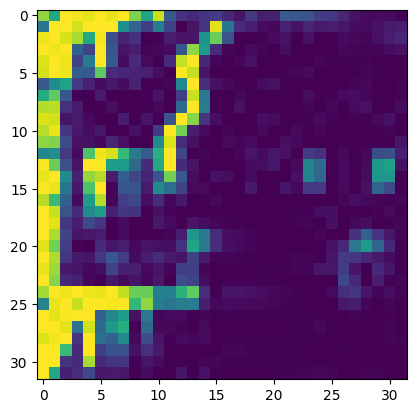

torch.Size([1, 1, 32, 32])
torch.Size([32, 32, 1])


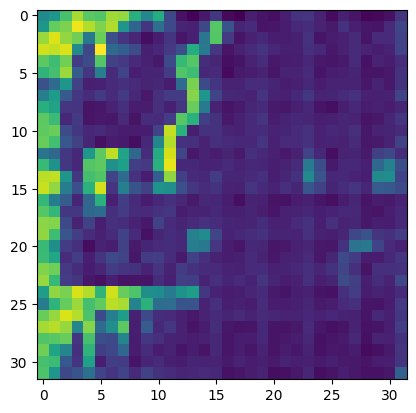

In [73]:
test_spec = Image.open("Data/SpectrogramsA/pop/pop_spec3.jpg")
make_tensor = torchvision.transforms.ToTensor()
test_spec = transform(test_spec)
test_spec = torch.transpose(test_spec, 0, 2)

fig, axs = plt.subplots(1)
axs.imshow(test_spec)
plt.show()


test_spec = torch.transpose(test_spec, 0, 2)
test_spec = torch.unsqueeze(test_spec, 0)
# test_spec = torch.transpose(test_spec, 0, 1)

print(test_spec.shape)
# test1, test2 = slice_images(test_spec)
# test_spec1 = generator(test1)
# test_spec2 = generator(test2)
# test_spec = assemble_images(test_spec1, test_spec2)
test_spec = generator(test_spec)

test_spec = torch.squeeze(test_spec, 0)
test_spec = torch.transpose(test_spec, 0, 2)

print(test_spec.shape)
fig, axs = plt.subplots(1)
axs.imshow(test_spec.detach())
plt.show()



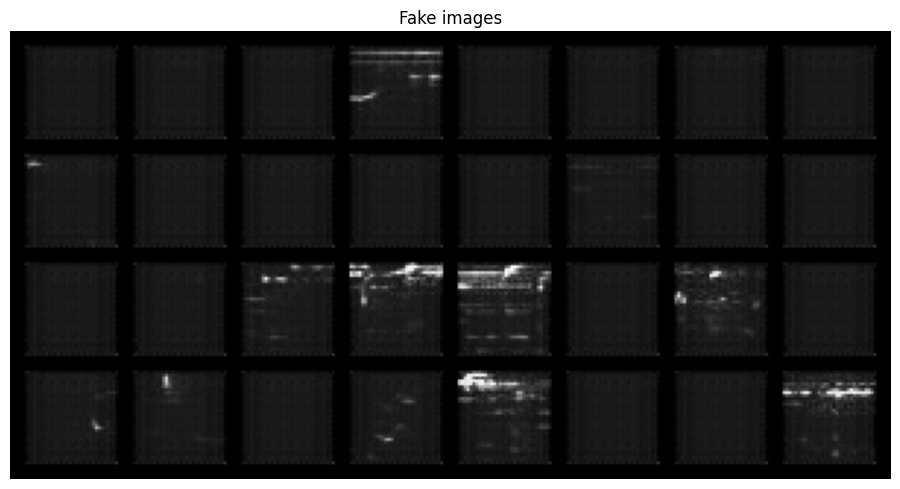

In [74]:
rock_batch = next(iter(dataloader_B))
p = rock_batch[0]
res = generator(p)
#b1, b2 = slice_images(rock_batch)
# p1 = generator(b1)
# p2 = generator(b2)
# p = assemble_images(p1, p2)

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake images")
plt.imshow(np.transpose(torchvision.utils.make_grid(res.to(device), padding=5, normalize=True).cpu(),(1,2,0)))



# plt.subplot()
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(res.detach(),(1,2,0)))
# plt.show()

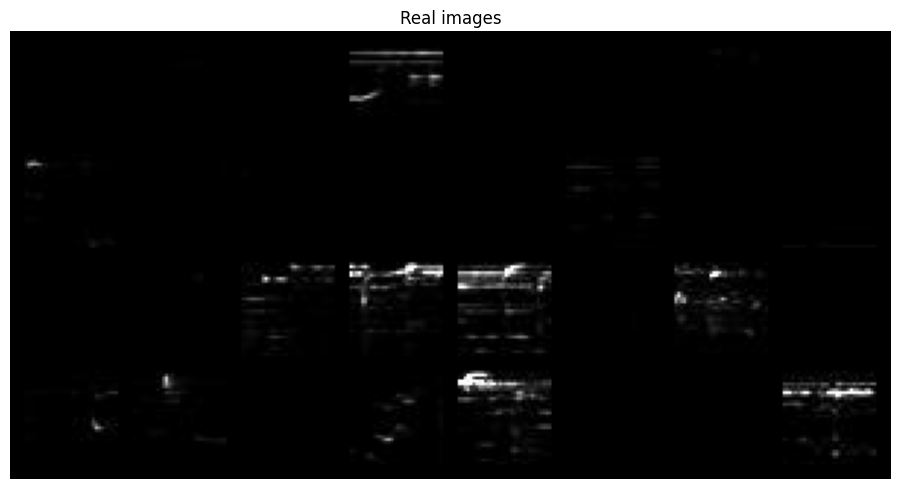

In [75]:
# real_batch = next(iter(dataloader))
real_batch = next(iter(dataloader_A))

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(torchvision.utils.make_grid(rock_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(img_lists[-1],(1,2,0)))
# plt.show()

In [76]:
print("1")

1
